# Projeto 2 - CDados

### Autores: Diego Guimarães Nuñez, Felipe Bakowski Nantes de Souza, Gustavo de Lima Mota

### Tema: Conseguimos prever o número de homicídios da cidade de São Paulo por ano?

### Features: PIB de São Paulo, Índice do Custo de Vida (ICV), Escolaridade, Tráfico de Drogas e Desemprego.

In [84]:
import basedosdados as bd
import pandas as pd
import matplotlib.pyplot as plt

### Baixando as bases de dados utilizadas no projeto:

In [3]:
homicidio = bd.read_table(dataset_id='br_sp_gov_ssp',
table_id='ocorrencias_registradas',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 153876/153876 [00:30<00:00, 5028.38rows/s]


In [4]:
homicidio

,ano,mes,id_municipio,regiao_ssp,homicidio_doloso,numero_de_vitimas_em_homicidio_doloso,homicidio_doloso_por_acidente_de_transito,numero_de_vitimas_em_homicidio_doloso_por_acidente_de_transito,homicidio_culposo_por_acidente_de_transito,homicidio_culposo_outros,...,total_de_estupro,estupro,estupro_de_vulneravel,total_de_roubo_outros,roubo_outros,roubo_de_veiculo,roubo_a_banco,roubo_de_carga,furto_outros,furto_de_veiculo
0,2002,1,3500105,Presidente Prudente,0,0,0,0,0,0,...,0,<NA>,<NA>,0,<NA>,0,0,0,21,0
1,2002,2,3500105,Presidente Prudente,0,0,0,0,0,0,...,0,<NA>,<NA>,0,<NA>,0,0,0,32,0
2,2002,3,3500105,Presidente Prudente,0,0,0,0,0,0,...,0,<NA>,<NA>,0,<NA>,0,0,0,36,0
3,2002,4,3500105,Presidente Prudente,0,0,0,0,0,0,...,0,<NA>,<NA>,1,<NA>,0,0,0,45,0
4,2002,5,3500105,Presidente Prudente,0,0,0,0,0,0,...,0,<NA>,<NA>,1,<NA>,0,0,0,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153871,2014,8,3500204,São José do Rio Preto,0,0,0,0,0,0,...,1,<NA>,<NA>,0,<NA>,0,0,0,3,0
153872,2014,9,3500204,São José do Rio Preto,0,0,0,0,0,0,...,0,<NA>,<NA>,0,<NA>,0,0,0,0,0
153873,2014,10,3500204,São José do Rio Preto,0,0,0,0,0,0,...,0,<NA>,<NA>,0,<NA>,0,0,0,3,0
153874,2014,11,3500204,São José do Rio Preto,0,0,0,0,0,0,...,0,<NA>,<NA>,0,<NA>,0,0,0,4,1


In [5]:
ivs = bd.read_table(dataset_id='br_ipea_avs',
table_id='municipio',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 319681/319681 [06:29<00:00, 821.03rows/s] 


In [6]:
ivs # colunas que serão usadas para feature: "ivs", "ivs_infraestrutura_urbana", "ivs_capital_humano" e "ivs_renda_trabalho"
# índice de vulnerabilidade social.

,ano,sigla_uf,id_municipio,raca_cor,sexo,localizacao,ivs,ivs_infraestrutura_urbana,ivs_capital_humano,ivs_renda_trabalho,...,populacao_15_mais,populacao_15_17,populacao_15_24,populacao_16_18,populacao_18_mais,populacao_18_20,populacao_18_24,populacao_19_21,populacao_25_mais,populacao_65_mais
0,2000,AP,1600105,branco,total,total,0.572,0.775,0.573,0.369,...,606,80,225,76,526,56,145,58,381,44
1,2000,AP,1600279,branco,total,total,0.677,0.880,0.649,0.503,...,4765,507,1855,509,4258,761,1347,717,2911,129
2,2000,AP,1600303,branco,total,total,0.379,0.292,0.435,0.411,...,52086,5786,18687,5953,46301,5854,12902,5839,33399,2392
3,2000,AP,1600402,branco,total,total,0.656,0.777,0.622,0.569,...,889,105,335,120,784,120,229,104,555,55
4,2000,AP,1600535,branco,total,total,0.615,0.713,0.691,0.441,...,1387,101,452,117,1285,176,351,174,935,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319676,2010,MG,3104007,negro,mulher,rural,NaN,NaN,NaN,NaN,...,258,0,98,0,258,30,98,41,160,8
319677,2010,MG,3115508,negro,mulher,rural,NaN,NaN,NaN,NaN,...,77,0,14,0,77,0,14,0,63,0
319678,2010,MG,3133105,negro,mulher,rural,NaN,NaN,NaN,NaN,...,121,0,5,0,121,5,5,5,116,19
319679,2010,MG,3168705,negro,mulher,rural,NaN,NaN,NaN,NaN,...,38,0,0,0,38,0,0,0,38,0


In [60]:
ivs.columns

Index(['ano', 'sigla_uf', 'id_municipio', 'raca_cor', 'sexo', 'localizacao',
       'ivs', 'ivs_infraestrutura_urbana', 'ivs_capital_humano',
       'ivs_renda_trabalho', 'idhm', 'idhm_l', 'idhm_e', 'idhm_r',
       'idhm_subescolaridade', 'idhm_subfrequencia', 'prosperidade_social',
       'proporcao_vulnerabilidade_socioeconomica', 'propocao_energia_eletrica',
       'proporcao_domicilio_densidade', 'proporcao_sem_agua_esgoto',
       'proporcao_sem_coleta', 'renda_per_capita', 'renda_media_18_mais',
       'proporcao_sem_renda_18_mais', 'renda_trabalho',
       'renda_per_capita_vulneravel', 'proporcao_vulneravel',
       'populacao_vulneravel_15_24', 'proporcao_vulneravel_dependente_idoso',
       'populacao_vulneravel_e_idoso', 'razao_dependencia',
       'fecundidade_total', 'taxa_envelhecimento', 'mortalidade_1_menos',
       'proporcao_mortalidade_5_menos', 'proporcao_crianca_fora_escola_0_5',
       'proporcao_escola_5_6', 'proporcao_crianca_fora_escola_6_14',
       'proporca

## Refletindo sobre os problemas sociais presentes em São Paulo, um dos mais notáveis é a abundante taxa de criminalidade, especificando ainda mais, a taxa de homicídio. Visado a target (problema o qual é pretendido visualizar), foi-se pensado em possíveis targets quais estão ligadas com o tema tido em vista, que são: Desemprego, Nível de Escolaridade, Produto Interno Bruto (PIB), Custo de Vida (ICV) e Índice de Vulnerabilidade Social (ICV).
## Tendo em vista a target com suas respectivas features, é pretendido realizar a criação de um modelo com capacidade de previsão para a criminalidade, entendendo intrinsicamente as relações individuais de cada feature com a target. A partir da criação do modelo, é facilitada a visão das 'raízes' do problema, possibilitando possíveis tomadas de decisões pessoais e governamentais para tratar esse severo problema.

#### Primeiramente, vamos tratar a base de dados de homicidios e deixá-la mais visualizável

In [63]:
homicidio['Homicidio_total'] = homicidio.loc[:, ['homicidio_doloso', 'homicidio_culposo_outros']].sum(axis=1) #homicidio total
homicidio = homicidio.loc[(homicidio['ano'] == 2010)]
homicidio_filtrado = homicidio.loc[:,('ano','id_municipio', 'regiao_ssp', 'Homicidio_total')] #selecionando colunas

In [64]:
homicidio_filtrado

,ano,id_municipio,regiao_ssp,Homicidio_total
46224,2010,3500105,Presidente Prudente,0.0
46225,2010,3500105,Presidente Prudente,0.0
46226,2010,3500105,Presidente Prudente,0.0
46227,2010,3500105,Presidente Prudente,0.0
46228,2010,3500105,Presidente Prudente,0.0
...,...,...,...,...
53899,2010,3500204,São José do Rio Preto,0.0
53900,2010,3500204,São José do Rio Preto,0.0
53901,2010,3500204,São José do Rio Preto,0.0
53902,2010,3500204,São José do Rio Preto,0.0


In [65]:
homicidio_ano = homicidio_filtrado.groupby(['ano', 'id_municipio', 'regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()
homicidio_ano

,ano,id_municipio,regiao_ssp,Homicidio_total
0,2010,3500105,Presidente Prudente,1.0
1,2010,3500204,São José do Rio Preto,1.0
2,2010,3500303,Piracicaba,1.0
3,2010,3500402,Piracicaba,2.0
4,2010,3500501,Campinas,0.0
...,...,...,...,...
635,2010,3557006,Sorocaba,6.0
636,2010,3557105,São José do Rio Preto,12.0
637,2010,3557154,São José do Rio Preto,0.0
638,2010,3557204,Bauru,1.0


 ## Agora devemos tratar a base IVS, para que, consigamos utilizar as colunas:  Prop_crianca_fora_escola_6_14, IDHM (IDH por municipio), Proporção_vulnerabilidade_socioeconomica (proporção de pessoas com renda per capita inferior a meio salario mínimo e que gastam mais de uma hora até chegar no trabalho), proporção_sem_agua_esgoto, Índice de Gini

In [61]:
ivs_filtrado = ivs.loc[:,('ano','id_municipio','sigla_uf','idhm','proporcao_crianca_fora_escola_6_14','proporcao_vulnerabilidade_socioeconomica', 'proporcao_sem_agua_esgoto','indice_gini')]
ivs_t = ivs_filtrado.loc[(ivs['sigla_uf'] == 'SP') & (ivs['ano'] == 2010)]

In [78]:
ivs_novo = ivs_t.dropna()
ivs_novo2 = ivs_novo.drop_duplicates(subset='id_municipio', keep = 'first')
ivs_novo2

,ano,id_municipio,sigla_uf,idhm,proporcao_crianca_fora_escola_6_14,proporcao_vulnerabilidade_socioeconomica,proporcao_sem_agua_esgoto,indice_gini
227507,2010,3500105,SP,0.819,1.81,2.38,0.00,0.52
227508,2010,3500204,SP,0.735,1.51,5.45,0.00,0.39
227509,2010,3500303,SP,0.742,3.70,9.76,0.49,0.51
227510,2010,3500709,SP,0.774,2.94,14.06,0.00,0.41
227511,2010,3500758,SP,0.736,0.60,2.68,0.61,0.44
...,...,...,...,...,...,...,...,...
228147,2010,3554805,SP,0.799,1.32,7.63,0.83,0.53
228148,2010,3555406,SP,0.781,2.64,3.00,1.50,0.62
228922,2010,3504701,SP,0.669,1.09,8.62,0.00,0.38
228948,2010,3507209,SP,0.745,5.35,13.75,7.19,0.40


In [82]:
tabela_final = pd.merge(ivs_novo2, homicidio_ano[['id_municipio', 'Homicidio_total']], on='id_municipio', how='left')
tabela_definitiva = tabela_final.dropna()
tabela_definitiva

,ano,id_municipio,sigla_uf,idhm,proporcao_crianca_fora_escola_6_14,proporcao_vulnerabilidade_socioeconomica,proporcao_sem_agua_esgoto,indice_gini,Homicidio_total
0,2010,3500105,SP,0.819,1.81,2.38,0.00,0.52,1.0
1,2010,3500204,SP,0.735,1.51,5.45,0.00,0.39,1.0
2,2010,3500303,SP,0.742,3.70,9.76,0.49,0.51,1.0
3,2010,3500709,SP,0.774,2.94,14.06,0.00,0.41,3.0
4,2010,3500758,SP,0.736,0.60,2.68,0.61,0.44,0.0
...,...,...,...,...,...,...,...,...,...
640,2010,3554805,SP,0.799,1.32,7.63,0.83,0.53,7.0
641,2010,3555406,SP,0.781,2.64,3.00,1.50,0.62,21.0
642,2010,3504701,SP,0.669,1.09,8.62,0.00,0.38,1.0
643,2010,3507209,SP,0.745,5.35,13.75,7.19,0.40,0.0


## Tabela definitiva criada!



# Plotando os gráficos de correlação!

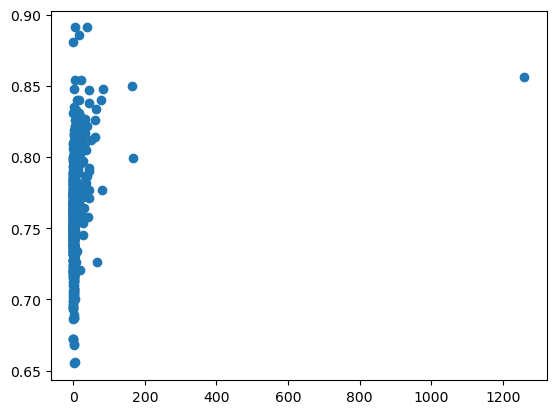

In [85]:
plt.scatter(tabela_definitiva['Homicidio_total'], tabela_definitiva['idhm'])
plt.show()

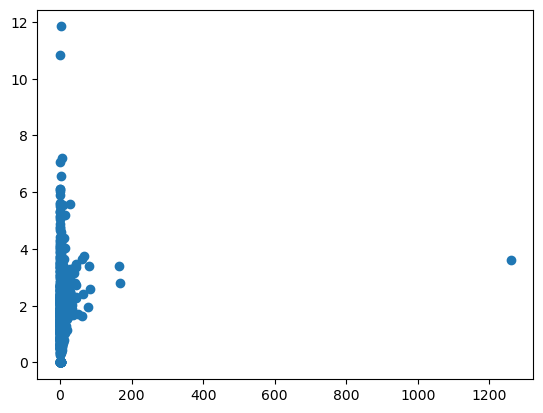

In [86]:
plt.scatter(tabela_definitiva['Homicidio_total'], tabela_definitiva['proporcao_crianca_fora_escola_6_14'])
plt.show()

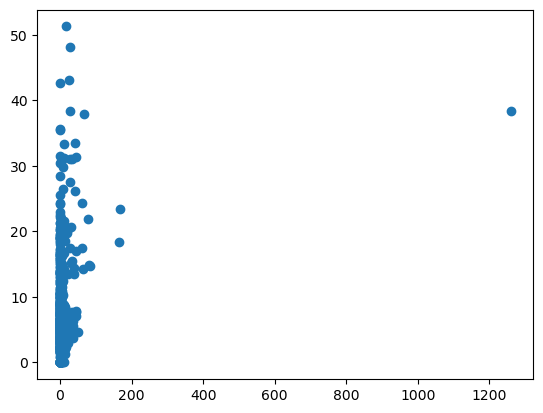

In [87]:
plt.scatter(tabela_definitiva['Homicidio_total'], tabela_definitiva['proporcao_vulnerabilidade_socioeconomica'])
plt.show()

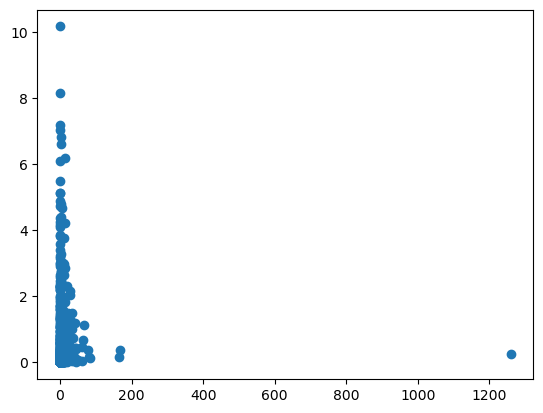

In [88]:
plt.scatter(tabela_definitiva['Homicidio_total'], tabela_definitiva['proporcao_sem_agua_esgoto'])
plt.show()

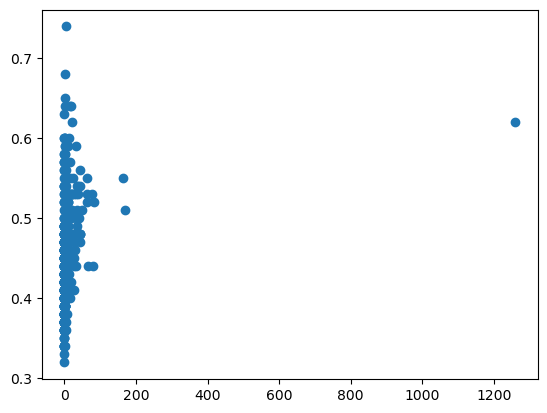

In [89]:
plt.scatter(tabela_definitiva['Homicidio_total'], tabela_definitiva['indice_gini'])
plt.show()